In [1]:
import requests # used for getting data from a URL
from pprint import pprint # pretty print
import pandas as pd # used for turning results into mini databases
from solrq import Q # used to turn result queries into the right format
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?" # the rest of the URL used for PDBe's search API.


In [2]:
def make_request(search_dict, number_of_rows=10):
    """
    makes a get request to the PDBe API
    :param dict search_dict: the terms used to search
    :param number_of_rows: number or rows to return - limited to 10
    :return dict: response JSON
    """
    if 'rows' not in search_dict:
        search_dict['rows'] = number_of_rows
    search_dict['wt'] = 'json'
    #pprint(search_dict)
    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))

    return {}


In [3]:
def format_search_terms(search_terms, filter_terms=None):
    ret = {'q': str(search_terms)}
    if filter_terms:
        fl = '{}'.format(','.join(filter_terms))
        ret['fl'] = fl
    return ret

In [4]:
def run_search(search_terms, filter_terms=None, number_of_rows=100):
    search_term = format_search_terms(search_terms, filter_terms)

    response = make_request(search_term, number_of_rows)
    results = response.get('response', {}).get('docs', [])
    print('Number of results: {}'.format(len(results)))
    return results


In [5]:
def make_positive_angles(x):
    for i in range(len(x)):
        if x[i] < 0:
            x[i] = np.degrees(x[i]) + 360
        else:
            x[i] = np.degrees(x[i])
    return x


In [6]:
def calc_dihedrals_from_pdb(definitions,output):
    
    dihedrals = {0: [],
                 1: [],
                 2: [],
                 3: [],
                 4: [],
                 5: [],
                }

    for RESnames in definitions:
        search_terms = Q(bound_compound_id = RESnames)
        #search_terms = Q(pdb_id = '6nhh')
        filter_terms = ['pdb_id', 'experimental_method','interacting_ligands','entity_id']
        first_results = run_search(search_terms, filter_terms)

        for i in first_results:
            print("analyzing: " + i.get('pdb_id'))
            url = 'https://files.rcsb.org/download/' + i.get('pdb_id') + '.pdb'
            r = requests.get(url)
            pdbFILEpath = '../scratch/' + i.get('pdb_id') + '.pdb' 
    
            with open(pdbFILEpath, 'wb') as f:
                f.write(r.content)
            
            try:
                t = md.load(pdbFILEpath)
            except:
                print('pdb file' + i.get('pdb_id') + 'not found')
                continue
                
            for dih in range(len(definitions.get(RESnames))):
                atom1=t.topology.select("resname == '" + str(RESnames) + "' and name == " + definitions.get(RESnames)[dih][0])
                atom2=t.topology.select("resname == '" + str(RESnames) + "' and name == " + definitions.get(RESnames)[dih][1])
                atom3=t.topology.select("resname == '" + str(RESnames) + "' and name == " + definitions.get(RESnames)[dih][2])
                atom4=t.topology.select("resname == '" + str(RESnames) + "' and name == " + definitions.get(RESnames)[dih][3])
                try:
                    index=[[atom1[0],atom2[0],atom3[0],atom4[0]]]
                except:
                    print('Atoms were not found from ' + i.get('pdb_id'))
                    continue
                #print(index)
                x=md.compute_dihedrals(t,index)
                #print(i.get('pdb_id'), make_positive_angles(x)[0],i.get('experimental_method'))
                result = [make_positive_angles(x)[0][0] , i.get('pdb_id'), i.get('entity_id'), i.get('experimental_method')[0]]
                #print(result)
                try:
                    if dihedrals[dih][-1][1] == result[1] and dihedrals[dih][-1][2] < result[2]:
                        dihedrals[dih][-1] = result
                    else:
                        dihedrals[dih].append(result)
                except:
                    dihedrals[dih].append(result)
                    
    for dih in dihedrals:
        dihVALUES = []
        [dihVALUES.append(dihedrals[dih][i][0]) for i in range(len(dihedrals[dih])) if dihedrals[dih][i][0] not in dihVALUES]
        fig= plt.figure(figsize=(5,5))
        dist = plt.hist(dihVALUES, bins=range(0,360,10), density=True)
        outfile=open('./' + output + str(dih) + '.dat','w')
        for i in range(len(dist[0])):
            #print(str(dist[1][i]),str(dist[0][i]))
            outfile.write(str(dist[1][i]) + " " + str(dist[0][i]) + "\n")
        outfile.close()


Number of results: 9
analyzing: 3kaa
analyzing: 1dsy
analyzing: 3bib
analyzing: 6b8o
analyzing: 6roh


/home/osollila/.local/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


analyzing: 6snd
analyzing: 6snd
analyzing: 6snd
analyzing: 6roh
Number of results: 3
analyzing: 5c5x
analyzing: 5dye
analyzing: 3d9s
Number of results: 2
analyzing: 6u9v
analyzing: 6u9w
Number of results: 32
analyzing: 4b2z
analyzing: 6i3y
analyzing: 6i3y
analyzing: 6lcp
analyzing: 6lcp
analyzing: 6lkn
analyzing: 6lkn
analyzing: 6lcr
analyzing: 6lcr
analyzing: 6vp0
analyzing: 6sp2
analyzing: 7bsv
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 7bsu
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 7bsv
analyzing: 7bsu
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
analyzing: 6tt7
Number of results: 2
analyzing: 6k7m
analyzing: 6k7m
Number of results: 3
analyzing: 2hj6
analyzing: 2hj6
analyzing: 2hj6
Number of results: 32
analyzing: 4hyt
analyzing: 4hyt
analyzing: 4hyt
analyzing: 4res
analyzing: 4res
analyzing: 4res
analyzing: 4ret
analyzing: 4ret
analyzin

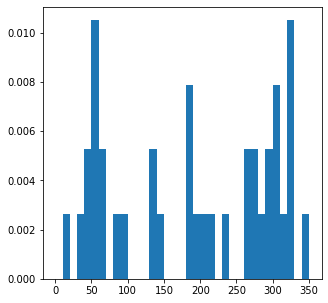

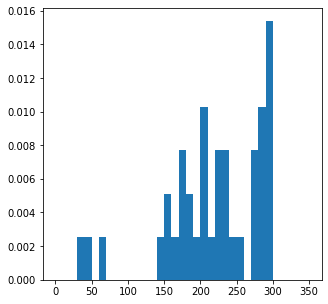

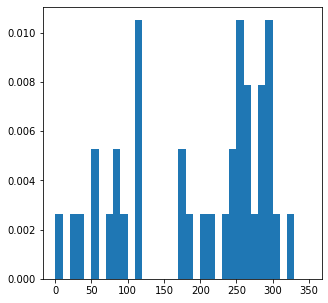

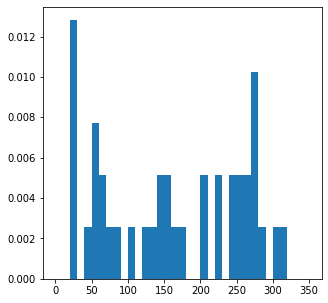

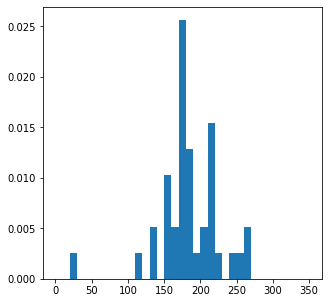

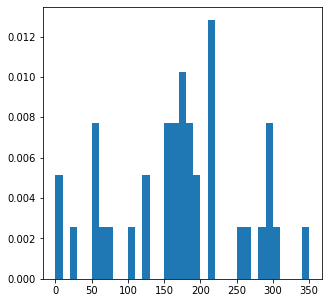

In [202]:
PSnames = {"PSF" : 
           [["O1","CB","CA","N"],["P","O1","CB","CA"],["O2","P","O1","CB"],["C2","O2","P","O1"],["C3","C2","O2","P"],["C4","C3","C2","O2"]],           
          "PS6" :
           [["O1","CB","CA","N"],["P","O1","CB","CA"],["O2","P","O1","CB"],["C2","O2","P","O1"],["C3","C2","O2","P"],["C4","C3","C2","O2"]],
          "Q3G" :
           [["O28","C29","C30","N34"],["P25","O28","C29","C30"],["O24","P25","O28","C29"],["C23","O24","P25","O28"],["C22","C23","O24","P25"],["C21","C22","C23","O24"]],
          "P5S" :
           [["OG","CB","CA","N"],["P12","OG","CB","CA"],["O16","P12","OG","CB"],["C3","O16","P12","OG"],["C2","C3","O16","P12"],["C1","C2","C3","O16"]],
          "D39" :
           [["O","C1","C","N"],["P","O","C1","C"],["O3","P","O","C1"],["C2","O3","P","O"],["C3","C2","O3","P"],["C4","C3","C2","O3"]],
          "PS2" :
           [["O4P","C4","C5","N5"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
          "17F" :
          [["O3","C1","C2","N1"],["P1","O3","C1","C2"],["O6","P1","O3","C1"],["C4","O6","P1","O3"],["C5","C4","O6","P1"],["C6","C5","C4","O6"]],
          "8SP" :
          [["OG","CB","CA","N"],["P","OG","CB","CA"],["O3G","P","OG","CB"],["C3G","O3G","P","OG"],["C2G","C3G","O3G","P"],["C1G","C2G","C3G","O3G"]],
         }

calc_dihedrals_from_pdb(PSnames,'PS')

Number of results: 40
analyzing: 4opc
analyzing: 4phz
analyzing: 4phz
analyzing: 4phz
analyzing: 4phz
analyzing: 4doj
analyzing: 4c7r
analyzing: 4jrb
Atoms were not found from 4jrb
Atoms were not found from 4jrb
Atoms were not found from 4jrb
analyzing: 5azb
analyzing: 5azc
analyzing: 2hhk
analyzing: 2hhk
analyzing: 2hhk
analyzing: 3mtx
analyzing: 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
analyzing: 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
Atoms were not found from 3rg1
analyzing: 6mi7


/home/osollila/.local/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:198: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


analyzing: 6mi7
analyzing: 6mi7
analyzing: 6mi7
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tjv
analyzing: 6tyi
analyzing: 6tyi
Number of results: 3
analyzing: 2hhk
analyzing: 2hhk
analyzing: 2hhk
Number of results: 100
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4tnk
analyzing: 4v62
pdb file4v62not found
analyzing: 4v62
pdb file4v62not found
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr
analyzing: 4ixr


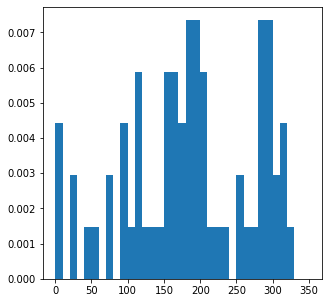

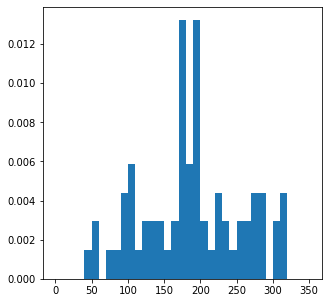

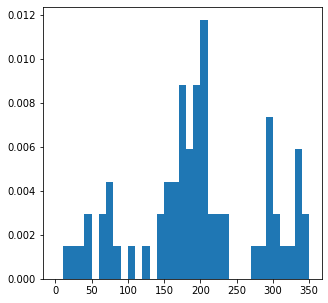

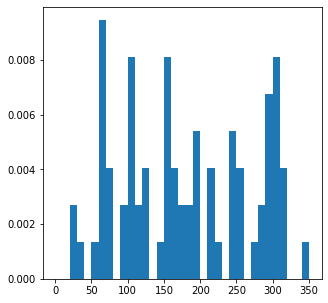

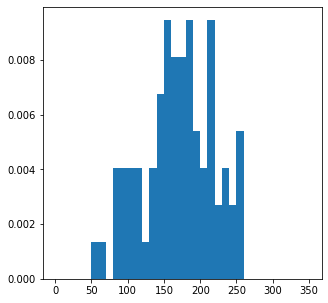

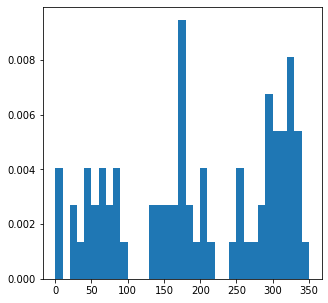

In [213]:
PGnames = {"PGT" : 
           [["O4P","C4","C5","C6"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
           "PGK" : 
           [["O4P","C4","C5","C6"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
           "LHG" :
          [["O3","C3","C2","C1"],["P","O3","C3","C2"],["O6","P","O3","C3"],["C4","O6","P","O3"],["C5","C4","O6","P"],["C6","C5","C4","O6"]],
           "44G" : 
           [["O4P","C4","C5","C6"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C10","C2","C1","O3P"]],
           "PGV" : 
           [["O12","C04","C05","C06"],["P","O12","C04","C05"],["O11","P","O12","C04"],["C03","O11","P","O12"],["C02","C03","O11","P"],["C01","C02","C03","O11"]],
           "OZ2" : 
           [["OP3","CG1","CG2","CG3"],["P","OP3","CG1","CG2"],["O3G","P","OP3","CG1"],["C3G","O3G","P","OP3"],["C2G","C3G","O3G","P"],["C1G","C2G","C3G","O3G"]],
           "D3D" : 
           [["O5","C19","C20","C21"],["P","O5","C19","C20"],["O2","P","O5","C19"],["C18","O2","P","O5"],["C17","C18","O2","P"],["C16","C17","C18","O2"]],
         "PGW" : 
           [["O12","C04","C05","CAD"],["P","O12","C04","C05"],["O11","P","O12","C04"],["C03","O11","P","O12"],["C02","C03","O11","P"],["C01","C02","C03","O11"]],
         "DR9" : 
           [["OBN","CBO","CBP","CBQ"],["PBM","OBN","CBO","CBP"],["OBL","PBM","OBN","CBO"],["CBK","OBL","PBM","OBN"],["CBE","CBK","OBL","PBM"],["CAB","CBE","CBK","OBL"]],
         "P6L" : 
           [["O12","C1","C2","C50"],["P11","O12","C1","C2"],["O9","P11","O12","C1"],["C7","O9","P11","O12"],["C5","C7","O9","P11"],["C6","C5","C7","O9"]], 
          "PG8" :
          [["O3","C1","C2","C3"],["P1","O3","C1","C2"],["O6","P1","O3","C1"],["C4","O6","P1","O3"],["C5","C4","O6","P1"],["C6","C5","C4","O6"]],
          "H3T" :
          [["O26","C27","C28","C30"],["P23","O26","C27","C28"],["O22","P23","O26","C27"],["C21","O22","P23","O26"],["C01","C21","O22","P23"],["C02","C01","C21","O22"]],
           "GOT" :
          [["O26","C27","C28","C30"],["P23","O26","C27","C28"],["O22","P23","O26","C27"],["C21","O22","P23","O26"],["C01","C21","O22","P23"],["C02","C01","C21","O22"]],
          }

calc_dihedrals_from_pdb(PGnames,'PG')

Number of results: 3
analyzing: 5kym
analyzing: 1tmx
Atoms were not found from 1tmx
Atoms were not found from 1tmx
Atoms were not found from 1tmx
Atoms were not found from 1tmx
Atoms were not found from 1tmx
analyzing: 3n9t
Number of results: 2
analyzing: 1lsh
analyzing: 1lsh
Number of results: 4
analyzing: 5ej1
analyzing: 5ej1
analyzing: 5ej1
analyzing: 4i9j
Number of results: 24
analyzing: 2h26
analyzing: 2h26
analyzing: 3b7q
analyzing: 3hhy
Atoms were not found from 3hhy
Atoms were not found from 3hhy
Atoms were not found from 3hhy
Atoms were not found from 3hhy
analyzing: 3hj8
Atoms were not found from 3hj8
Atoms were not found from 3hj8
Atoms were not found from 3hj8
Atoms were not found from 3hj8
analyzing: 3hjq
Atoms were not found from 3hjq
Atoms were not found from 3hjq
Atoms were not found from 3hjq
Atoms were not found from 3hjq
analyzing: 3hgi
Atoms were not found from 3hgi
Atoms were not found from 3hgi
Atoms were not found from 3hgi
Atoms were not found from 3hgi
analyzin

/home/samuli/.local/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


analyzing: 6rqf
analyzing: 6rqf
analyzing: 6rqf
analyzing: 6rqf
analyzing: 6rqf
analyzing: 6rqf
analyzing: 6rqf
Number of results: 3
analyzing: 5irz
analyzing: 5irx
analyzing: 5irx
Number of results: 6
analyzing: 2hh1
analyzing: 2hh1
analyzing: 2hg9
analyzing: 2hg9
analyzing: 2hg9
analyzing: 2hh1
Number of results: 99
analyzing: 4ekw
analyzing: 4mvm
Atoms were not found from 4mvm
Atoms were not found from 4mvm
analyzing: 4mvu
Atoms were not found from 4mvu
Atoms were not found from 4mvu
analyzing: 4mvz
Atoms were not found from 4mvz
Atoms were not found from 4mvz
analyzing: 4mw3
Atoms were not found from 4mw3
Atoms were not found from 4mw3
analyzing: 4mw8
Atoms were not found from 4mw8
Atoms were not found from 4mw8
analyzing: 4mto
Atoms were not found from 4mto
Atoms were not found from 4mto
analyzing: 4mvs
Atoms were not found from 4mvs
Atoms were not found from 4mvs
analyzing: 5ek0
analyzing: 5h36
Atoms were not found from 5h36
Atoms were not found from 5h36
Atoms were not found fro

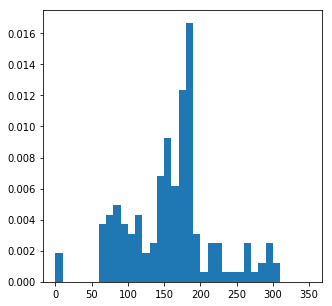

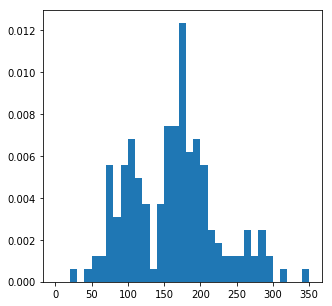

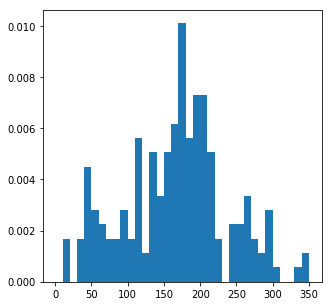

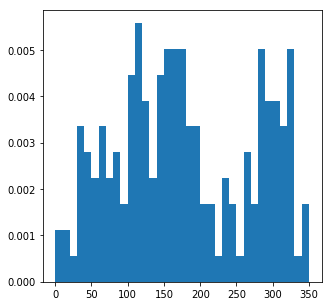

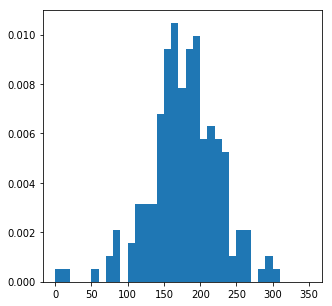

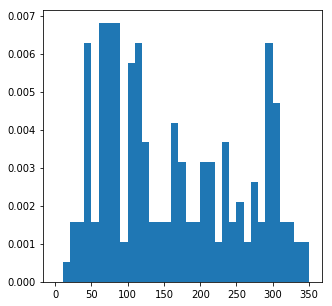

In [7]:
PCnames = {"PLC" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
          "PX4" :
          [["O3","C1","C2","N1"],["P1","O3","C1","C2"],["O4","P1","O3","C1"],["C6","O4","P1","O3"],["C7","C6","O4","P1"],["C8","C7","C6","O4"]],
          "6PL" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "LIO" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "HGX" : 
           [["O5","C4","C5","N1"],["P1","O5","C4","C5"],["O3P","P1","O5","C4"],["C1","O3P","P1","O5"],["C2","C1","O3P","P1"],["C3","C2","C1","O3P"]],
        "PC7" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "PC8" :
          [["O3","C1","C2","N1"],["P1","O3","C1","C2"],["O4","P1","O3","C1"],["C6","O4","P1","O3"],["C7","C6","O4","P1"],["C8","C7","C6","O4"]],
        "P1O" :
          [["O3","C1","C2","N1"],["P1","O3","C1","C2"],["O4","P1","O3","C1"],["C6","O4","P1","O3"],["C7","C6","O4","P1"],["C8","C7","C6","O4"]],
        "6O8" :
          [["O15","C16","C17","N18"],["P12","O15","C16","C17"],["O11","P12","O15","C16"],["C10","O11","P12","O15"],["C09","C10","O11","P12"],["C08","C09","C10","O11"]],
        "XP5" :
          [["O3","C1","C2","N1"],["P1","O3","C1","C2"],["O4","P1","O3","C1"],["C6","O4","P1","O3"],["CAM","C6","O4","P1"],["C8","CAM","C6","O4"]],
        "EGY" :
          [["O13","C11","C12","N"],["P","O13","C11","C12"],["O11","P","O13","C11"],["C1","O11","P","O13"],["C2","C1","O11","P"],["C3","C2","C1","O11"]],
        "PLD" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "SBM" : 
           [["O5","C4","C5","N1"],["P","O5","C4","C5"],["O3P","P","O5","C4"],["C1","O3P","P","O5"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "HXG" : 
           [["OAW","CAP","CAS","NBC"],["PBD","OAW","CAP","CAS"],["OAX","PBD","OAW","CAP"],["CAU","OAX","PBD","OAW"],["CBB","CAU","OAX","PBD"],["CAT","CBB","CAU","OAX"]],
        "PCW" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
          }

calc_dihedrals_from_pdb(PCnames,'PC')

In [ ]:
PEnames = {"8PE" :
          [["O13","C11","C12","N"],["P","O13","C11","C12"],["O11","P","O13","C11"],["C1","O11","P","O13"],
                ["C2","C1","O11","P"],["C3","C2","C1","O11"]],
        "PTY" :
          [["O11","C3","C2","N1"],["P1","O11","C3","C2"],["O14","P1","O11","C3"],["C5","O14","P1","O11"],
                ["C6","C5","O14","P1"],["C1","C6","C5","O14"]],
        "3PE" :
          [["O13","C11","C12","N"],["P","O13","C11","C12"],["O11","P","O13","C11"],["C1","O11","P","O13"],
                ["C2","C1","O11","P"],["C3","C2","C1","O11"]],
        "PEH" :
          [["O12","C11","C12","N"],["P","O13","C11","C12"],["O11","P","O13","C11"],["C1","O11","P","O13"],
                ["C2","C1","O11","P"],["C3","C2","C1","O11"]],
        "PEF" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],
                ["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "6OE" : 
           [["O04","C03","C02","N01"],["P05","O04","C03","C02"],["O08","P05","O04","C03"],
                ["C09","O08","P05","O04"],["C10","C09","O08","P05"],["C11","C10","C09","O08"]],
        "6O9" : 
           [["O04","C03","C02","N01"],["P05","O04","C03","C02"],["O08","P05","O04","C03"],
                ["C09","O08","P05","O04"],["C10","C09","O08","P05"],["C11","C10","C09","O08"]],
        "9PE" :
          [["O13","C11","C12","N"],["P","O13","C11","C12"],["O11","P","O13","C11"],["C1","O11","P","O13"],
                ["C2","C1","O11","P"],["C3","C2","C1","O11"]],
        "PEV" : 
           [["O4P","C4","C5","N6"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],
                ["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "46E" :
          [["O13","C11","C12","N"],["P","O13","C11","C12"],["O11","P","O13","C11"],["C1","O11","P","O13"],
                ["C2","C1","O11","P"],["C3","C2","C1","O11"]],
         "SBJ" : 
           [["O4P","C4","C5","N6"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],
                ["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "L9Q" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],
                ["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "PEK" : 
           [["O12","C04","C05","N"],["P","O12","C04","C05"],["O11","P","O12","C04"],["C03","O11","P","O12"],
                ["C02","C03","O11","P"],["C01","C02","C03","O11"]],
        "EPH" : 
           [["O8","C38","C39","N1"],["P1","O8","C38","C39"],["O5","P1","O8","C38"],["C37","O5","P1","O8"],
                ["C2","C37","O5","P1"],["C1","C2","C37","O5"]],
        "ZPE" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],
                ["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
        "9TL" : 
           [["OBA","CBB","CBC","NBD"],["PAZ","OBA","CBB","CBC"],["OAY","PAZ","OBA","CBB"],["CAX","OAY","PAZ","OBA"],
                ["CAW","CAX","OAY","PAZ"],["CAV","CAW","CAX","OAY"]],
        "9Y0" : 
           [["O1","C3","C4","N"],["P","O1","C3","C4"],["O3","P","O1","C3"],["C2","O3","P","O1"],
                ["C1","C2","O3","P"],["C","C1","C2","O3"]],
        "6OU" : 
           [["O26","C27","C28","N29"],["P23","O26","C27","C28"],["O22","P23","O26","C27"],["C21","O22","P23","O26"],
                ["C20","C21","O22","P23"],["C19","C20","C21","O22"]],
        "LOP" : 
           [["O1","C2","C1","N1"],["P1","O1","C2","C1"],["O2","P1","O1","C2"],["C3","O2","P1","O1"],
                ["C4","C3","O2","P1"],["C5","C4","C3","O2"]],
        "PEE" : 
           [["O4P","C4","C5","N"],["P","O4P","C4","C5"],["O3P","P","O4P","C4"],["C1","O3P","P","O4P"],
                ["C2","C1","O3P","P"],["C3","C2","C1","O3P"]],
                  }

calc_dihedrals_from_pdb(PEnames,'PE')

In [195]:
outfile=open('./tst.dat','w')
for i in range(len(dist[0])):
    print(str(dist[1][i]),str(dist[0][i]))
    outfile.write(str(dist[1][i]) + " " + str(dist[0][i]) + "\n")
outfile.close()

0 0.005128205128205128
10 0.0
20 0.002564102564102564
30 0.0
40 0.0
50 0.007692307692307692
60 0.002564102564102564
70 0.002564102564102564
80 0.0
90 0.0
100 0.002564102564102564
110 0.0
120 0.005128205128205128
130 0.0
140 0.0
150 0.007692307692307692
160 0.007692307692307692
170 0.010256410256410256
180 0.007692307692307692
190 0.005128205128205128
200 0.0
210 0.01282051282051282
220 0.0
230 0.0
240 0.0
250 0.002564102564102564
260 0.002564102564102564
270 0.0
280 0.002564102564102564
290 0.007692307692307692
300 0.002564102564102564
310 0.0
320 0.0
330 0.0
340 0.002564102564102564


In [190]:
print('1st search - more rows')
search_terms = Q(molecule_name="Dihydrofolate reductase")

first_results_more_rows = run_search(search_terms, number_of_rows=1000)


1st search - more rows
Number of results: 405


In [123]:
print('2nd search')
search_terms = Q(pdb_id="6snd")
second_results = run_search(search_terms)

for i in second_results:
    print(i.get('entity_id'), i.get('_version_'), i.get('deposition_date'))

2nd search
Number of results: 3
1 1679819100281372672 2019-08-23T01:00:00Z
2 1679819100285566976 2019-08-23T01:00:00Z
3 1679819100288712704 2019-08-23T01:00:00Z


In [8]:
pprint(second_results[0])

{'_version_': 1678985289647783936,
 'abstracttext_unassigned': ['The crystal structures of six human '
                             'dihydrofolate reductase (hDHFR) ternary '
                             'complexes with NADPH and a series of mixed E/Z '
                             'isomers of 5-substituted '
                             '5-[2-(2-methoxyphenyl)-prop-1-en-1-yl]furo[2,3-d]pyrimidine-2,4-diamines '
                             'substituted at the C9 position with propyl, '
                             'isopropyl, cyclopropyl, butyl, isobutyl and '
                             'sec-butyl (E2-E7, Z3) were determined and the '
                             'results were compared with the resolved E and Z '
                             'isomers of the C9-methyl parent compound. The '
                             'configuration of all of the inhibitors, save '
                             'one, was observed as the E isomer, in which the '
                             'binding o

In [9]:
print('There are {} available search terms'.format(len(second_results[0].keys())))
print(second_results[0].keys())
keys_without_q = [q for q in second_results[0].keys() if not (q.startswith('q_') or (q.startswith('t_')))]
print(len(keys_without_q))

There are 448 available search terms
dict_keys(['abstracttext_unassigned', 't_abstracttext_unassigned', 'q_abstracttext_unassigned', 'all_assembly_composition', 't_molecule_info', 'q_all_assembly_composition', 'all_assembly_form', 'q_all_assembly_form', 'all_assembly_id', 'q_all_assembly_id', 'all_assembly_mol_wt', 'q_all_assembly_mol_wt', 'all_assembly_type', 'q_all_assembly_type', 'all_authors', 'q_all_authors', 'all_molecule_names', 'q_all_molecule_names', 'all_num_interacting_entity_id', 'q_all_num_interacting_entity_id', 'assembly_composition', 'q_assembly_composition', 'assembly_form', 'q_assembly_form', 'assembly_id', 'q_assembly_id', 'assembly_mol_wt', 'q_assembly_mol_wt', 'assembly_num_component', 'q_assembly_num_component', 'assembly_type', 'q_assembly_type', 'beam_source_name', 'q_beam_source_name', 'biological_cell_component', 'all_go_terms', 'q_all_go_terms', 't_all_go_terms', 'q_biological_cell_component', 'biological_function', 'q_biological_function', 'biological_proces

In [12]:
print(second_results[0].get('pdb_id'))
print(second_results[0].get('experimental_method'))
print(second_results[0].get('interacting_ligands'))

3nxv
['X-ray diffraction']
['SO4 : SULFATE ION', 'NDP : NADPH DIHYDRO-NICOTINAMIDE-ADENINE-DINUCLEOTIDE PHOSPHATE', 'D2F : 5-[(1E)-2-(2-methoxyphenyl)hex-1-en-1-yl]furo[2,3-d]pyrimidine-2,4-diamine']


In [18]:
print('3rd search')
search_terms = Q(pdb_id="3bib")
filter_terms = ['pdb_id', 'experimental_method','interacting_ligands']
third_results = run_search(search_terms, filter_terms)
pprint(third_results)

3rd search
Number of results: 1
[{'experimental_method': ['X-ray diffraction'],
  'interacting_ligands': ['NA : SODIUM ION',
                          'PSF : 1,2-DICAPROYL-SN-PHOSPHATIDYL-L-SERINE'],
  'pdb_id': '3bib'}]
